## Imports

In [1]:
import pandas as pd
import json
from matplotlib_venn import venn3, venn2
from matplotlib import pyplot as plt

# Identifying results from hypedsearch and SpectrumMill

We would like to breakdown the results from `hypedsearch` and `SpectrumMill` in order to have an idea of what needs to be improved upon. Here are the steps we need to take:

1. Load in the truth set and non truth sets from the hacky false positive run
2. For each of these resuts, match them up by their `id` values
    1. Add the entry to a table of the form
        ```python
        {
            'id': {
                'truth': bool, 
                'entry': dict
            }
        }
        ```
3. Load in `SpectrumMill` results and split into hybrid and non hybrid results
4. For every entry in these two sets:
    1. Look into our FP table
    2. Determine if this is an overlap by checking to see if the sequences are the same
    3. Put in a list of either `true positive overlaps` or `false positive overlaps` 
5. Show the overlap

## Constants

In [2]:
# hypedsearch results
results_dir = '/Users/zacharymcgrath/Desktop/Experiment output/FP/'
truth_results_json = results_dir + 'truth/summary.json'
non_truth_results_json = results_dir + 'not_truth/summary.json'

# specmill results
specmil_results_file = '/Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3_results.ssv'


## 1. Load in the truth and non truth sets

In [3]:
truth_results = json.load(open('/Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3/output/summary.json', 'r'))
non_truth_results = json.load(open(non_truth_results_json, 'r'))

# save them in a dictionary by their id so that we can compare
ided_truth = {v['spectrum']['id'].replace('.pkl', ''): v for _, v in truth_results.items()}
ided_non_truth = {v['spectrum']['id'].replace('.pkl', ''): v for _, v in non_truth_results.items()}

## 2. Create a table for the hyped search results

In [4]:
# first get all the id's of both 
all_ids = list(set(list(ided_truth.keys()) + list(ided_non_truth.keys())))

tp_rate_table = {}

for _id in all_ids:
    
    # see if its in truth and not the other
    if _id in ided_truth and _id not in ided_non_truth:
        tp_rate_table[_id] = {'truth': True, 'entry': ided_truth[_id]}
        continue
        
    # see if its in non truth and not the other
    if _id in ided_non_truth and _id not in ided_truth:
        tp_rate_table[_id] = {'truth': False, 'entry': ided_non_truth[_id]}
        continue
        
    # otherwise check the scores and sequences to see which one wins out
    forward_entries = ided_truth[_id]['alignments']
    reverse_entries = ided_non_truth[_id]['alignments']
    
    # see if one or the other is empty
    if len(forward_entries) == 0 and len(reverse_entries) == 0:
        continue
        
    elif len(forward_entries) == 0 and len(reverse_entries) > 0:
        tp_rate_table[_id] = {'truth': False, 'entry': reverse_entries}
        continue
        
    elif len(forward_entries) >0 and len(reverse_entries) == 0:
        tp_rate_table[_id] = {'truth': True, 'entry': forward_entries}
        continue
        
    # get the best scores
    best_forward_score = sorted(forward_entries, key=lambda x: x['total_score'], reverse=True)[0]['total_score']
    best_reverse_score = sorted(reverse_entries, key=lambda x: x['total_score'], reverse=True)[0]['total_score']
    
    # get all the sequences associated with them
    best_forward_seqs = [x['sequence'] for x in forward_entries if x['total_score'] >= best_forward_score]
    best_reverse_seqs = [x['sequence'] for x in reverse_entries if x['total_score'] >= best_reverse_score]
    
    # if the forward score is better than reverse, take it
    if best_forward_score > best_reverse_score:
        tp_rate_table[_id] = {'truth': True, 'entry': forward_entries}
        
    # otherwise if any of the top sequnces match we count it as true
    elif any([x == y for x in best_forward_seqs for y in best_reverse_seqs]):
        tp_rate_table[_id] = {'truth': True, 'entry': forward_entries}
        
    # otherwise its the reverse
    else:
        tp_rate_table[_id] = {'truth': False, 'entry': reverse_entries}

In [5]:
tp_count = len([k for k, v in tp_rate_table.items() if v["truth"]])
fp_count = len([k for k, v in tp_rate_table.items() if not v["truth"]])

print(f'True positive count: {tp_count}')
print(f'False positive count: {fp_count}')

True positive count: 900
False positive count: 186


In [6]:

# the the number of hyped search predicted hybrids and non hybrids
# num_hs_tp_hybrids = len(
#     [k for k, v in tp_rate_table.items() \
#     if v['truth'] and len([x for x in v['entry'] if 'hybrid_sequence' in x]) > len(v['entry']) * .75]
# )
num_hs_tp_hybrids = len(
    [k for k, v in tp_rate_table.items() \
    if v['truth'] and len([x for x in v['entry'] if 'hybrid_sequence' in x]) == len(v['entry'])]
)


# num_hs_fp_hybrids = len(
#     [k for k, v in tp_rate_table.items() \
#     if not v['truth'] and len([x for x in v['entry'] if 'hybrid_sequence' in x]) > len(v['entry']) * .75]
# )
num_hs_fp_hybrids = len(
    [k for k, v in tp_rate_table.items() \
    if not v['truth'] and len([x for x in v['entry'] if 'hybrid_sequence' in x]) == len(v['entry'])]
)

print(f'True positive hybrid count: {num_hs_tp_hybrids}')
print(f'False positive hybrid count: {num_hs_fp_hybrids}')

True positive hybrid count: 2
False positive hybrid count: 19


In [7]:
num_hs_tp_non_hybrids = tp_count - num_hs_tp_hybrids
num_hs_fp_non_hybrids = fp_count - num_hs_fp_hybrids

print(f'True positive non hybrid count: {num_hs_tp_non_hybrids}')
print(f'False positive non hybrid count: {num_hs_fp_non_hybrids}')

True positive non hybrid count: 898
False positive non hybrid count: 167


## 3. Load in `SpectrumMill` results

In [8]:
specmil_results = pd.read_csv(specmil_results_file, sep=';')

# get the hybrids 
specmil_hybs = specmil_results.loc[specmil_results['entry_name'].str.contains('HYBRID')]
ided_specmil_hybs = {row['filename']: row['sequence'] for _, row in specmil_hybs.iterrows()}

# get the non hybrids
specmil_non_hybs = specmil_results.loc[~specmil_results['entry_name'].str.contains('HYBRID')]
ided_specmil_non_hybs = {row['filename']: row['sequence'] for _, row in specmil_non_hybs.iterrows()}

## 4. Determine the overlap for the hybrid case and the non hybrid case

In [9]:
hybrid_tp_sm_overlap = []
hybrid_fp_sm_overlap = []

non_hybrid_tp_sm_overlap = []
non_hybrid_fp_sm_overlap = []

missed_hyb_ids = []

i = 0

# go through spec mill hybrids first
for _id, entry in ided_specmil_hybs.items():

    # see if its in the tp_rate_table
    if _id in tp_rate_table:
        
        tp_entry = tp_rate_table[_id]
                
        # pick the list to append to by if its true or false 
        appending_list = hybrid_tp_sm_overlap if tp_entry['truth'] else hybrid_fp_sm_overlap
                    
        # replace all I and Ls with B and see if any of the sequences match
        sm_hybrid = entry.replace('I', 'B').replace('L', 'B')
        
        found = False
        
        # go through each sequence
        for a in tp_entry['entry']:
            hs_hybrid = a['sequence'].replace('I', 'B').replace('L', 'B')
                        
            if hs_hybrid == sm_hybrid: 
                appending_list.append((entry, tp_rate_table[_id], _id))
                found = True
                break
                
        if not found:
            missed_hyb_ids.append(_id)
        
                
# next do the non hybrids
for _id, entry in ided_specmil_non_hybs.items():
        
    # see if its in the tp_rate_table
    if _id in tp_rate_table:
        
        tp_entry = tp_rate_table[_id]
                
        # pick the list to append to by if its true or false 
        appending_list = non_hybrid_tp_sm_overlap if tp_entry['truth'] else non_hybrid_fp_sm_overlap
                    
        # replace all I and Ls with B and see if any of the sequences match
        sm_hybrid = entry.replace('I', 'B').replace('L', 'B')
        
        # go through each sequence
        for a in tp_entry['entry']:
            hs_hybrid = a['sequence'].replace('I', 'B').replace('L', 'B')
                        
            if hs_hybrid == sm_hybrid: 
                appending_list.append((entry, tp_rate_table[_id], _id))
                
            

## 5. Show the overlaps

1. Hybrids
    1. True positive rates
    2. False positive rates
    
2. Non hybrids
    1. True positive rates
    2. False positive rates

### 5.1 Hybrids

Text(0.5, 1.0, 'Hybrid sequnce alignments')

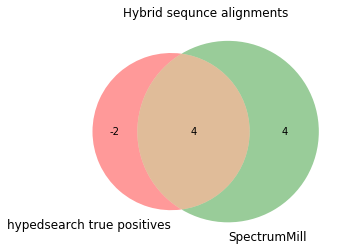

In [10]:
# hyped search, spectrum mill, overlap
venn2(
    subsets=(
        num_hs_tp_hybrids - len(hybrid_tp_sm_overlap), 
        len(ided_specmil_hybs) - len(hybrid_tp_sm_overlap), 
        len(hybrid_tp_sm_overlap)
    ),
    set_labels=('hypedsearch true positives', 'SpectrumMill')
)
plt.title('Hybrid sequnce alignments')

Text(0.5, 1.0, 'Hybrid sequnce alignments')

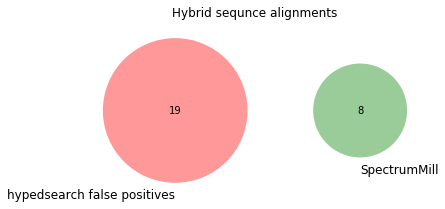

In [11]:
# hyped search, spectrum mill, overlap
venn2(
    subsets=(
        num_hs_fp_hybrids - len(hybrid_fp_sm_overlap), 
        len(ided_specmil_hybs) - len(hybrid_fp_sm_overlap), 
        len(hybrid_fp_sm_overlap)
    ),
    set_labels=('hypedsearch false positives', 'SpectrumMill')
)
plt.title('Hybrid sequnce alignments')

### 5.2 Non hybrids

Text(0.5, 1.0, 'Non hybrid sequnce alignments')

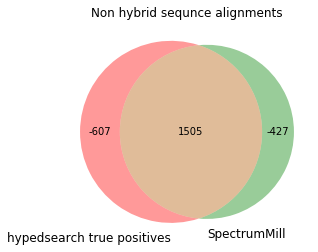

In [12]:
# hyped search, spectrum mill, overlap
venn2(
    subsets=(
        num_hs_tp_non_hybrids - len(non_hybrid_tp_sm_overlap), 
        len(ided_specmil_non_hybs) - len(non_hybrid_tp_sm_overlap), 
        len(non_hybrid_tp_sm_overlap)
    ),
    set_labels=('hypedsearch true positives', 'SpectrumMill')
)
plt.title('Non hybrid sequnce alignments')

Text(0.5, 1.0, 'Non hybrid sequnce alignments')

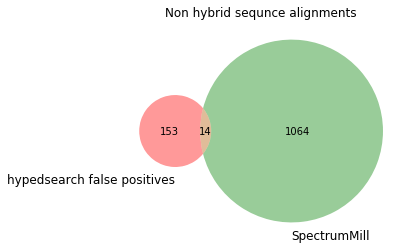

In [13]:
# hyped search, spectrum mill, overlap
venn2(
    subsets=(
        num_hs_fp_non_hybrids - len(non_hybrid_fp_sm_overlap), 
        len(ided_specmil_non_hybs) - len(non_hybrid_fp_sm_overlap), 
        len(non_hybrid_fp_sm_overlap)
    ),
    set_labels=('hypedsearch false positives', 'SpectrumMill')
)
plt.title('Non hybrid sequnce alignments')

In [14]:
[v for k, v in tp_rate_table.items() \
    if v['truth'] and len([x for x in v['entry'] if 'hybrid_sequence' in x]) == len(v['entry'])]

[{'truth': True,
  'entry': [{'left_proteins': [],
    'right_proteins': None,
    'sequence': 'VFDIDASKSLQNT',
    'hybrid_sequence': 'VFDIDA-SKSLQNT',
    'b_score': 2,
    'y_score': 2,
    'total_score': 3.5,
    'precursor_distance': 0.003267700000151308,
    'total_mass_error': 0.014751486875013597},
   {'left_proteins': [],
    'right_proteins': None,
    'sequence': 'NIKHKSTHECAGL',
    'hybrid_sequence': 'NIKHK-STHECAGL',
    'b_score': 2,
    'y_score': 2,
    'total_score': 3.0,
    'precursor_distance': 0.0016980333334686293,
    'total_mass_error': 0.009024943281161768},
   {'left_proteins': [],
    'right_proteins': None,
    'sequence': 'FSSFGPVQLLDID',
    'hybrid_sequence': 'FSSFGP-VQLLDID',
    'b_score': 2,
    'y_score': 2,
    'total_score': 2.5,
    'precursor_distance': 0.0019267000000127155,
    'total_mass_error': 0.008163471249986287},
   {'left_proteins': [],
    'right_proteins': None,
    'sequence': 'NIKHKPGGGWQCI',
    'hybrid_sequence': 'NIKHKPGGG-WQCI',

In [15]:
tp_rate_table['NOD2_E3.21510.21510.2']

{'truth': False,
 'entry': [{'proteins': [],
   'sequence': 'TIALATSPIL',
   'b_score': 5,
   'y_score': 3,
   'total_score': 8,
   'precursor_distance': 0.00019424999993589154,
   'total_mass_error': 0.008596747148459372},
  {'proteins': [],
   'sequence': 'LATITAPSLL',
   'b_score': 5,
   'y_score': 3,
   'total_score': 8,
   'precursor_distance': 0.00019424999999273496,
   'total_mass_error': 0.009930210468695577},
  {'proteins': [],
   'sequence': 'LATITASPLL',
   'b_score': 5,
   'y_score': 3,
   'total_score': 8,
   'precursor_distance': 0.00019424999999273496,
   'total_mass_error': 0.00993021046875242},
  {'proteins': ['REVERSE_ILF3_MOUSE'],
   'sequence': 'LDLDGKLLL',
   'b_score': 4,
   'y_score': 2,
   'total_score': 6,
   'precursor_distance': 0.00019474999993462916,
   'total_mass_error': 0.005737995898414283},
  {'proteins': ['REVERSE_ILF3_MOUSE'],
   'sequence': 'LDLDGKLLL',
   'b_score': 4,
   'y_score': 2,
   'total_score': 6,
   'precursor_distance': 0.000194749999934

## In depth analysis of missed hybrids

In [16]:
for _id in missed_hyb_ids:
    print(f'Correct hybrid sequence was: {ided_specmil_hybs[_id]}')
    
    print('Sorted forward (sequence, total score, b score, y score) and sorted reverse (sequence, total score, b score, y score)')
    
    num_res = max(len(ided_truth[_id]['alignments']), len(ided_non_truth[_id]['alignments']))

    f = ided_truth[_id]['alignments'] + [
        {'sequence': '', 'total_score': None, 'b_score': None, 'y_score': None} for _ in range(num_res - len(ided_truth[_id]['alignments']))
    ]
    r = ided_non_truth[_id]['alignments'] + [
        {'sequence': '', 'total_score': None, 'b_score': None, 'y_score': None} for _ in range(num_res - len(ided_non_truth[_id]['alignments']))
    ]
    
    for i in range(num_res):
        
        print(f'{f[i]["sequence"]} \t {f[i]["total_score"]} \t {f[i]["b_score"]} \t {f[i]["y_score"]} | {r[i]["sequence"]} \t {r[i]["total_score"]} \t {r[i]["b_score"]} \t {r[i]["y_score"]}')
    
    print()


Correct hybrid sequence was: DLQTLALLL
Sorted forward (sequence, total score, b score, y score) and sorted reverse (sequence, total score, b score, y score)
LATALTSPIL 	 7 	 4 	 3 | TIALATSPIL 	 8 	 5 	 3
LATALTSPLL 	 7 	 4 	 3 | LATITAPSLL 	 8 	 5 	 3
LATALTSPLI 	 7 	 4 	 3 | LATITASPLL 	 8 	 5 	 3
LATALTSPII 	 7 	 4 	 3 | LDLDGKLLL 	 6 	 4 	 2
DLQTLALIL 	 7.0 	 6 	 2 | LDLDGKLLL 	 6 	 4 	 2
DLQTLALII 	 7.0 	 6 	 2 | LATLNELIL 	 6.0 	 5 	 2
ALTITTGPLL 	 7 	 4 	 3 | LATLNELII 	 6.0 	 5 	 2
ALTITTLGPI 	 6 	 3 	 3 | TIALATPSLI 	 5.5 	 5 	 3
ALTITTPGLL 	 6.0 	 4 	 3 | TIALATPSII 	 5.5 	 5 	 3
ALTITTPGIL 	 6.0 	 4 	 3 | TIALATPSIL 	 5.5 	 5 	 3
ALTITTGPIL 	 6.0 	 4 	 3 | TIALATPSLL 	 5.5 	 5 	 3
ALTITTGPII 	 6.0 	 4 	 3 | TLALATSPIL 	 5.5 	 5 	 3
ITALAPSTLL 	 6 	 4 	 2 | TIALATSPLL 	 5.5 	 5 	 3
ALTITTLAPV 	 5.5 	 3 	 3 | TIALATSPLI 	 5.5 	 5 	 3
ALTITTLAVP 	 5.5 	 3 	 3 | TIALATSPII 	 5.5 	 5 	 3
ALTITTIAVP 	 5.5 	 3 	 3 | LATITAPSII 	 5.5 	 5 	 3
TLAITAPSLL 	 5.5 	 5 	 3 | LATITAPSIL 	 5